In [ ]:
!pip install tensorflow

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = 'rawframes_train'
WORKING_DIR = 'working'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [5]:
with open('multisports_GT.pkl', 'rb') as handle:
    dic = pickle.load(handle)
with open('captionDic.pkl', 'rb') as handle:
    cap_dic = pickle.load(handle)

In [6]:
import boto3
s3 = boto3.client('s3')

In [7]:
features = {}

In [ ]:
import io
import requests
import shutil
# extract features from image

directory = BASE_DIR

i = 0
for img in tqdm(cap_dic.keys()):
    if i == 10000:
        break
    # load the image from file
    img_path = directory + '/' + img
    
    url = s3.generate_presigned_url( ClientMethod='get_object', Params={ 'Bucket': 'aimprojectdataset', 'Key': img_path } )
    r = requests.get(url, stream = True)
    # Check if the image was retrieved successfully
    if r.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True

        # Open a local file with wb ( write binary ) permission.
        with open('img2.jpg','wb') as f:
            shutil.copyfileobj(r.raw, f)
    else:
        print('Image Couldn\'t be retreived')
        
#     object = s3.Object('aimprojectdataset',img_path)
#     image = load_img(io.BytesIO(object.get()['Body'].read()))
    image = load_img('img2.jpg', target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img.split('.')[0]
    # store feature
    features[image_id] = feature
    os.remove('img2.jpg')
    i = i + 1
#     print(i)

  0%|          | 0/92359 [00:00<?, ?it/s]

In [21]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features10000.pkl'), 'wb'))

In [20]:
print(len(features))

10000


In [22]:
with open('captions.txt', 'r') as f:
    captions_doc = f.read()

In [23]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    if image_id not in features.keys():
        continue
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/542041 [00:00<?, ?it/s]

In [12]:
print(mapping)

{'basketball/v_ERsBxGv2JxY_c013/00215': ['Player passes ball', 'Player makes a pass to another player', 'Another player recieves the ball from the player', 'Ball is thrown from player to another player', 'Ball is recieved by a player on the same team'], 'basketball/v_ERsBxGv2JxY_c013/00216': ['Player passes ball', 'Player makes a pass to another player', 'Another player recieves the ball from the player', 'Ball is thrown from player to another player', 'Ball is recieved by a player on the same team'], 'basketball/v_ERsBxGv2JxY_c013/00217': ['Player passes ball', 'Player makes a pass to another player', 'Another player recieves the ball from the player', 'Ball is thrown from player to another player', 'Ball is recieved by a player on the same team'], 'basketball/v_ERsBxGv2JxY_c013/00218': ['Player passes ball', 'Player makes a pass to another player', 'Another player recieves the ball from the player', 'Ball is thrown from player to another player', 'Ball is recieved by a player on the 

In [24]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [25]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [27]:
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer10000.pkl'), 'wb'))

In [28]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [29]:
#Train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [30]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

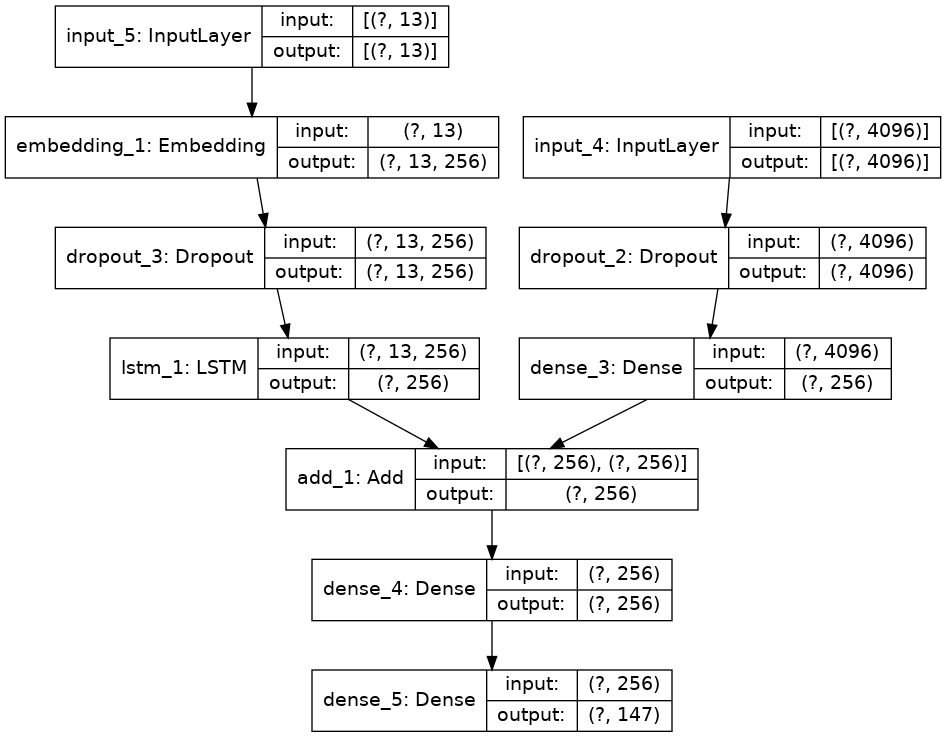

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [19]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [ ]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 46/140 [========>.....................] - ETA: 1:23 - loss: 3.6180

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model10000.h5')

In [34]:
from nltk.translate.bleu_score import corpus_bleu

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [35]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.763405
BLEU-2: 0.660075


In [44]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = image_name
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption[8:-6])
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred[8:-6])
    plt.imshow(image)

---------------------Actual---------------------
 player passes ball 
 player makes pass to another player 
 another player recieves the ball from the player 
 ball is thrown from player to another player 
 ball is recieved by player on the same team 
--------------------Predicted--------------------
 player moves towards net 


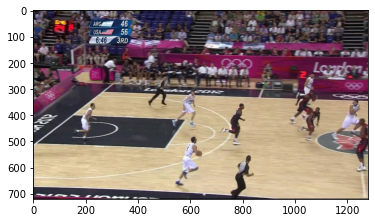

In [45]:
generate_caption('basketball/v_ERsBxGv2JxY_c013/00215.jpg')